In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Part 1 = Pseudoquant float64 / int8

In [ ]:
img = Image.open('download.jpg')
#img = Image.open('Passarin robô.png')
img = img.resize((64, 64))
target = np.array(img).reshape(1, -1)
target = (target/127.5) - 1.0
target = target.astype(np.float64)

print(target.shape)
print(target.min(), target.max())

(1, 12288)
-1.0 0.9843137254901961


In [ ]:
teste = target.astype('i2')
print(teste.min(), teste.max())
print(teste)

-1 0
[[0 0 0 ... 0 0 0]]


In [ ]:
class QuantNode:

    def __init__(self):

        pass

    def apply(self, parameter):

        alpha = max(np.abs(np.min(parameter)), np.abs(np.max(parameter)))

        scale = (2*alpha)/((2**8) - 1)

        #quant = np.floor(parameter/(scale+1e-8)).astype('i2')
        quant = np.floor(parameter/(scale+1e-8)).astype(np.int8)

        dequant = (quant*scale).astype(np.float64)

        return scale, quant, dequant

    def eval(self, parameter):

        alpha = max(np.abs(np.min(parameter)), np.abs(np.max(parameter)))

        scale = (2*alpha)/((2**8) - 1)

        #quant = np.floor(parameter/(scale+1e-8)).astype('i2')
        quant = np.floor(parameter/(scale+1e-8)).astype(np.int8)

        return scale, quant, None

In [ ]:
class BitLinear:

    def __init__(self, input_size, output_size, bias=True):

        super(BitLinear, self).__init__()

        self.quantizer = QuantNode()

        #self.weight = np.random.randint(-1, 2, (input_size, output_size), dtype=np.int16)
        #self.weight = np.random.normal(0.0, 1.0, (input_size, output_size)).astype(np.float64)
        #self.weight = np.random.randint(-1, 2, (input_size, output_size)).astype(np.int8)
        self.weight = np.random.normal(0.0, 0.1, (input_size, output_size)).astype(np.float64)

        self.bias = None

        self.scalew = None

        if bias:

            self.bias = np.zeros(output_size, dtype=np.float64)
            #self.bias = np.zeros(output_size, dtype=np.int8)
            self.scaleb = None

        self.dw = None

    def forward(self, input):

        self.dw = input

        self.scalew, q_weight, weight = self.quantizer.apply(self.weight)

        output = input @ weight

        if self.bias is not None:

            self.scaleb, q_bias, bias = self.quantizer.apply(self.bias)

            output += bias

        return output

    def backward(self):

        dl_dw = self.dw
        dl_di = self.weight

        return dl_dw, dl_di

    def eval(self, input):

        self.scalew, q_weight, _ = self.quantizer.eval(self.weight)

        output = input @ q_weight

        if self.bias is not None:

            self.scaleb, q_bias, _ = self.quantizer.eval(self.bias)

            output += q_bias

        return output

In [ ]:
class FCCModel:

    def __init__(self, eval=False):

        self.neuron1 = BitLinear(128, 1024)
        self.neuron2 = BitLinear(1024, 4096)
        self.neuron3 = BitLinear(4096, 4096)
        self.neuron4 = BitLinear(4096, 64*64*3)

        self.grads = None

        self.eval = eval

        self.quantizer = QuantNode()

        self.scale = None

    def forward(self, input):

        if self.eval is False:

            # out = w * x + b

            scale0, _, input = self.quantizer.apply(input)
            x = self.neuron1.forward(input)
            scale1, _, x = self.quantizer.apply(x)
            x = self.neuron2.forward(x)
            scale2, _, x = self.quantizer.apply(x)
            x = self.neuron3.forward(x)
            scale3, _, x = self.quantizer.apply(x)
            x = self.neuron4.forward(x)
            scale4, _, x = self.quantizer.apply(x)

            self.scale = (x+1e-8)

            return x

        else:

            # out*S = w*S1 * x*S0 + b*S2
            # out*S = (S1*S0)*(w*x) + b*S2
            # S = (S1*S0/out)*(w*x) + (S2/out)*b <---> out = (S1*S0/S)*(w*x) + (S2/S)*b
            # S = (w*S1*x*S0 + b*S2)/out <----> out = (w*S1*x*S0 + b*S2)/S

            _, input, _ = self.quantizer.eval(input)
            x = self.neuron1.eval(input)
            x = self.neuron2.eval(x)
            x = self.neuron3.eval(x)
            x = self.neuron4.eval(x)

            scale = x/self.scale

            x = x/(scale+1e-8)

            return x

    def backward(self):

        self.grads = []

        self.grads.append(self.neuron4.backward())
        self.grads.append(self.neuron3.backward())
        self.grads.append(self.neuron2.backward())
        self.grads.append(self.neuron1.backward())

        return self.grads

In [ ]:
save = []

save.append((model.neuron1.weight, model.neuron1.bias))
save.append((model.neuron2.weight, model.neuron2.bias))
save.append((model.neuron3.weight, model.neuron3.bias))
save.append((model.neuron4.weight, model.neuron4.bias))

In [ ]:
model = FCCModel()

In [ ]:
model.neuron1.weight, model.neuron1.bias = save[0]
model.neuron2.weight, model.neuron2.bias = save[1]
model.neuron3.weight, model.neuron3.bias = save[2]
model.neuron4.weight, model.neuron4.bias = save[3]

In [ ]:
#input = np.random.randint(-10, 11, (1, 128)).astype(np.int8)
input = np.random.normal(0, 0.01, (1, 128))

In [ ]:
print(model.neuron1.weight.min(), model.neuron1.weight.max())

-0.44934523338596605 0.422078495291152


In [ ]:
def roundclip(x, a, b):

    gamma = np.mean(np.abs(x))
    x = x/(gamma + 1e-8)

    return np.maximum(a, np.minimum(b, np.round(x)))

In [ ]:
def MSE(output, target):

    mse = (output - target)**2
    mse = np.mean(np.sum(mse, -1), 0)
    dmse = 2*(output - target)

    return mse, dmse

In [ ]:
def Adam(parameter, lr, grads, m=None, v=None, iteration=0):

    m = 0.9 * m + (1 - 0.9) * grads
    v = 0.999 * v + (1 - 0.999) * (grads ** 2)

    m_hat = m/(1 - (0.9 ** (iteration+1)))
    v_hat = v/(1 - (0.999 ** (iteration+1)))

    parameter = parameter - (lr * (m_hat/(np.sqrt(v_hat)+1e-8)))

    return parameter, m, v

25939.92466029863 0.4484170279204358


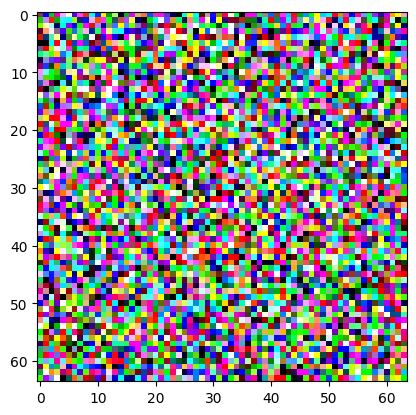

554.0705879212671 -0.01832434965862675


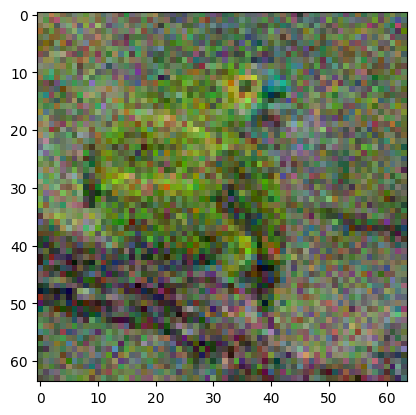

22.949906646806852 0.0026635047566248376


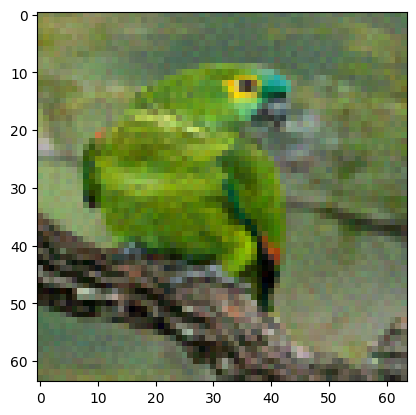

32.83896142651703 0.033487484837708796


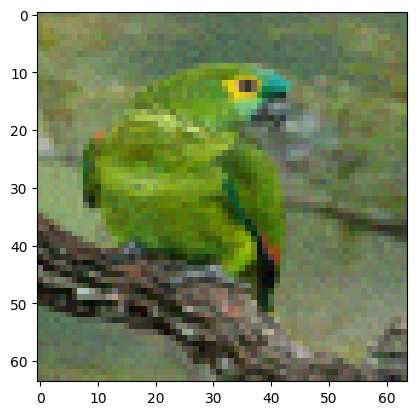

53.93669533423058 -0.05678856569324292


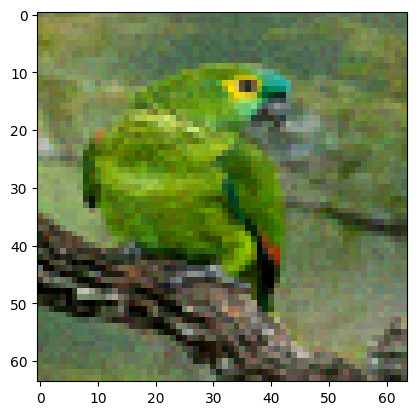

32.191236157853574 -0.014982970008464833


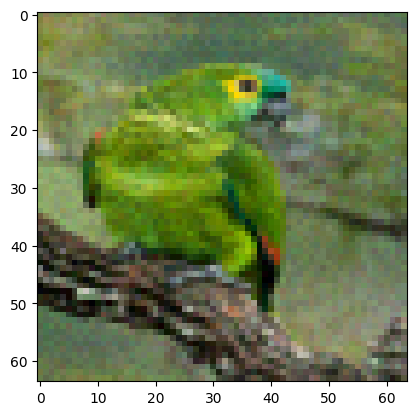

102.29778695710118 0.10241100309336704


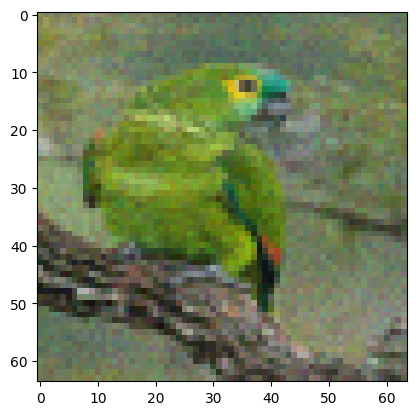

107.3914869748981 0.11591833100051335


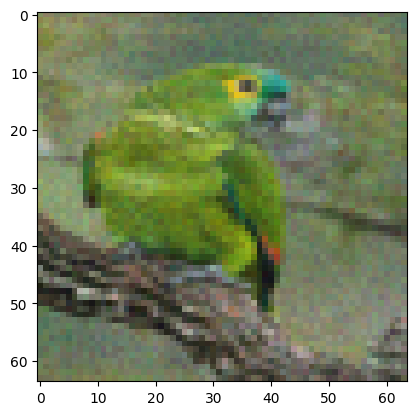

46.261854799860565 0.06261470086143704


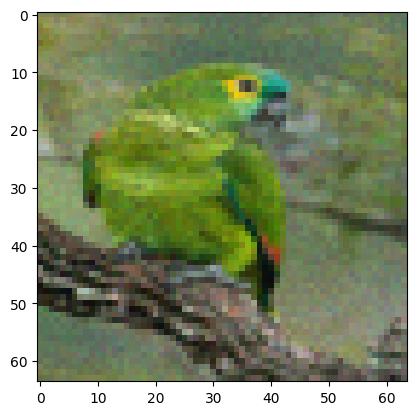

19.267494259373862 0.014408586753972765


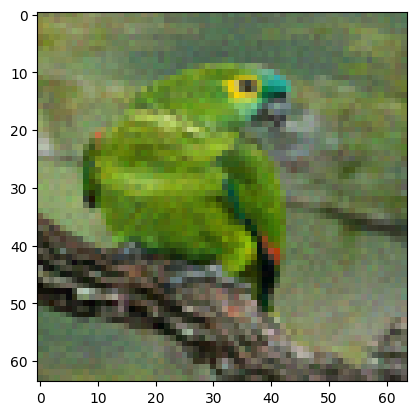

In [ ]:
losses = []
weights_mean = []
LR = 1e-3

m_weight4, m_bias4 = np.zeros_like(model.neuron4.weight), np.zeros_like(model.neuron4.bias)
m_weight3, m_bias3 = np.zeros_like(model.neuron3.weight), np.zeros_like(model.neuron3.bias)
m_weight2, m_bias2 = np.zeros_like(model.neuron2.weight), np.zeros_like(model.neuron2.bias)
m_weight1, m_bias1 = np.zeros_like(model.neuron1.weight), np.zeros_like(model.neuron1.bias)

v_weight4, v_bias4 = np.zeros_like(model.neuron4.weight), np.zeros_like(model.neuron4.bias)
v_weight3, v_bias3 = np.zeros_like(model.neuron3.weight), np.zeros_like(model.neuron3.bias)
v_weight2, v_bias2 = np.zeros_like(model.neuron2.weight), np.zeros_like(model.neuron2.bias)
v_weight1, v_bias1 = np.zeros_like(model.neuron1.weight), np.zeros_like(model.neuron1.bias)

for i in range(100):

    out = model.forward(input)

    loss, dmse = MSE(out, target)

    grads = model.backward()

    A = dmse @ grads[0][1].T
    B = A @ grads[1][1].T
    C = B @ grads[2][1].T

    w, m_weight4, v_weight4 = Adam(model.neuron4.weight, LR, (dmse.T * grads[0][0]).T, m_weight4, v_weight4, i)
    b, m_weight4, v_weight4 = Adam(model.neuron4.bias, LR, dmse.mean(0), m_bias4, v_bias4, i)
    model.neuron4.weight, model.neuron4.bias = w, b

    w, m_weight3, v_weight3 = Adam(model.neuron3.weight, LR, (A.T @ grads[1][0]).T, m_weight3, v_weight3, i)
    b, m_bias3, v_bias3 = Adam(model.neuron3.bias, LR, A.mean(0), m_bias3, v_bias3, i)
    model.neuron3.weight, model.neuron3.bias = w, b

    w, m_weight2, v_weight2 = Adam(model.neuron2.weight, LR, (B.T @ grads[2][0]).T, m_weight2, v_weight2, i)
    b, m_bias2, v_bias2 = Adam(model.neuron2.bias, LR, B.mean(0), m_bias2, v_bias2, i)
    model.neuron2.weight, model.neuron2.bias = w, b

    w, m_weight1, v_weight1 = Adam(model.neuron1.weight, LR, (C.T @ grads[3][0]).T, m_weight1, v_weight1, i)
    b, m_bias1, v_bias1 = Adam(model.neuron1.bias, LR, C.mean(0), m_bias1, v_bias1, i)
    model.neuron1.weight, model.neuron1.bias = w, b

    losses.append(loss)
    weights_mean.append(model.neuron1.weight.mean())

    if i % 10 == 0:

        print(loss, dmse.mean())
        plt.imshow(((out+1.0)*0.5).reshape(64, 64, 3))
        plt.show()

In [ ]:
out = model.forward(input)

loss, dmse = MSE(out, target)

In [ ]:
print(out)
print(loss)

[[ 0.00877854  0.08778535 -0.30724873 ... -0.36869848 -0.43892676
  -0.44770529]]
37.20007297468469


In [ ]:
print(model.scale)
print(model.scale.min(), model.scale.max(), np.array([model.scale == 0]).sum())

[[ 0.00877855  0.08778536 -0.30724872 ... -0.36869847 -0.43892675
  -0.44770528]]
-1.1236524908505339 0.9656388779184275 0


In [ ]:
model.eval = True

out = model.forward(input)

print(out.min(), out.max())
print(out)

loss, _ = MSE(out, target)

-1.1236524909575334 0.9656388778242398
[[ 0.          0.08778536 -0.30724872 ... -0.36869847 -0.43892675
  -0.44770528]]


44.90640793780749


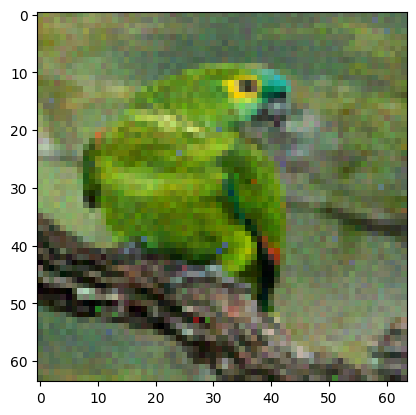

In [ ]:
print(loss)

plt.imshow(((out+1.0)*0.5).reshape(64, 64, 3))
plt.show()

# PART 2: Pseudoquant float64 / int2

In [ ]:
class QuantNode:

    def __init__(self):

        pass

    def apply(self, parameter):

        alpha = max(np.abs(np.min(parameter)), np.abs(np.max(parameter)))

        scale = (2*alpha)/((2**2) - 1)

        quant = np.floor(parameter/(scale+1e-8)).astype('i2')
        #quant = np.floor(parameter/(scale+1e-8)).astype(np.int8)

        dequant = (quant*scale).astype(np.float64)

        return scale, quant, dequant

    def eval(self, parameter):

        alpha = max(np.abs(np.min(parameter)), np.abs(np.max(parameter)))

        scale = (2*alpha)/((2**2) - 1)

        quant = np.floor(parameter/(scale+1e-8)).astype('i2')
        #quant = np.floor(parameter/(scale+1e-8)).astype(np.int8)

        return scale, quant, None

In [ ]:
def quantize(parameter):

    alpha = max(np.abs(np.min(parameter)), np.abs(np.max(parameter)))

    scale = (2*alpha)/((2**2) - 1)

    quant = np.floor(parameter/(scale+1e-8)).astype('i2')

    #return scale, quant, None
    return quant

def dequantize(parameter):

    alpha = max(np.abs(np.min(parameter)), np.abs(np.max(parameter)))

    scale = (2*alpha)/((2**2) - 1)

    dequant = (parameter*scale).astype(np.float64)

    #return scale, None, dequant
    return dequant

In [ ]:
class BitLinear:

    def __init__(self, input_size, output_size, bias=True):

        super(BitLinear, self).__init__()

        self.quantizer = QuantNode()

        #self.weight = np.random.randint(-1, 2, (input_size, output_size), dtype=np.int16)
        #self.weight = np.random.normal(0.0, 1.0, (input_size, output_size)).astype(np.float64)
        self.weight = np.random.randint(-1, 2, (input_size, output_size)).astype('i2')

        self.bias = None

        self.scalew = None

        if bias:

            self.bias = np.zeros(output_size, dtype=np.float64)
            self.scaleb = None

        self.dw = None

    def forward(self, input):

        self.dw = input

        output = input @ self.weight

        if self.bias is not None:

            output += self.bias

        return output

    def backward(self):

        dl_dw = self.dw
        dl_di = self.weight

        return dl_dw, dl_di

In [ ]:
class FCCModel:

    def __init__(self, eval=False):

        self.neuron1 = BitLinear(128, 1024)
        self.neuron2 = BitLinear(1024, 4096)
        self.neuron3 = BitLinear(4096, 4096)
        self.neuron4 = BitLinear(4096, 64*64*3)

        self.grads = None

        self.eval = eval

        self.quantizer = QuantNode()

        self.scale = None

    def forward(self, input):

        # out = w*S1 * x + b*S2 (?????)

        x = self.neuron1.forward(input)
        x = self.neuron2.forward(x)
        x = self.neuron3.forward(x)
        x = self.neuron4.forward(x)

        return x

    def backward(self):

        self.grads = []

        self.grads.append(self.neuron4.backward())
        self.grads.append(self.neuron3.backward())
        self.grads.append(self.neuron2.backward())
        self.grads.append(self.neuron1.backward())

        return self.grads

In [ ]:
model = FCCModel()

In [ ]:
def MSE(output, target):

    mse = (output - target)**2
    mse = np.mean(np.sum(mse, -1), 0)
    dmse = 2*(output - target)

    return mse, dmse

In [ ]:
def Adam(parameter, lr, grads, m=None, v=None, iteration=0):

    m = 0.9 * m + (1 - 0.9) * grads
    v = 0.999 * v + (1 - 0.999) * (grads ** 2)

    m_hat = m/(1 - (0.9 ** (iteration+1)))
    v_hat = v/(1 - (0.999 ** (iteration+1)))

    update = (lr * (m_hat/(np.sqrt(v_hat)+1e-8)))

    parameter = parameter - update
    #parameter = parameter - np.clip(update, -1, 1)

    return parameter, m, v

153991618444734.84 -222912.5676558671


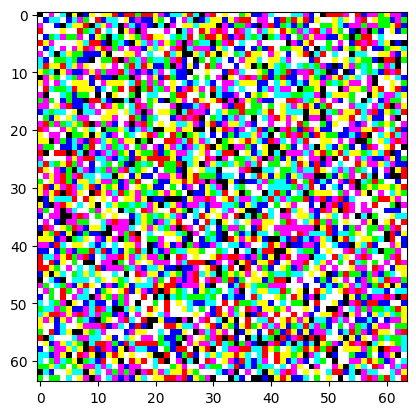

1.1646482269705462e+17 6151196.8130593905


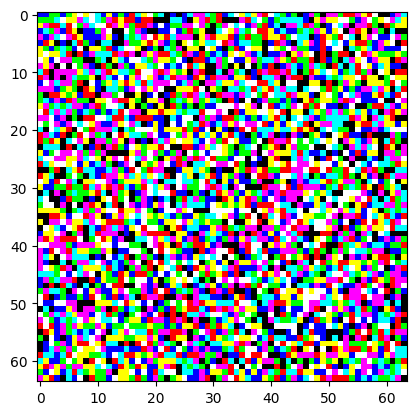

2.136371244301749e+16 2634452.9656228586


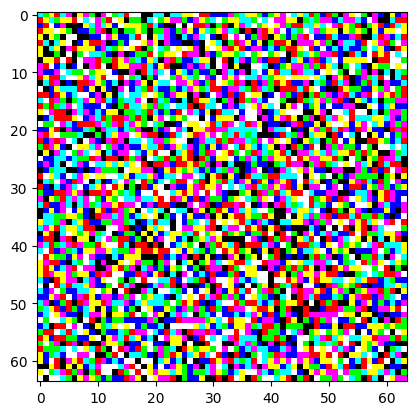

45148392070368.734 -119434.83725260594


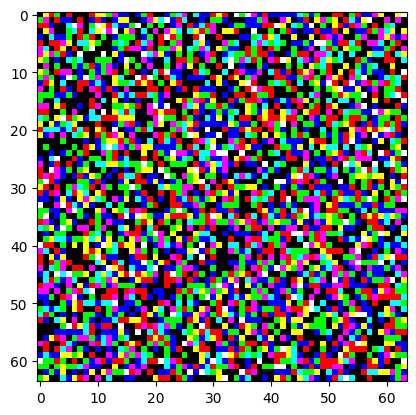

1946815327874384.5 -795037.4684005338


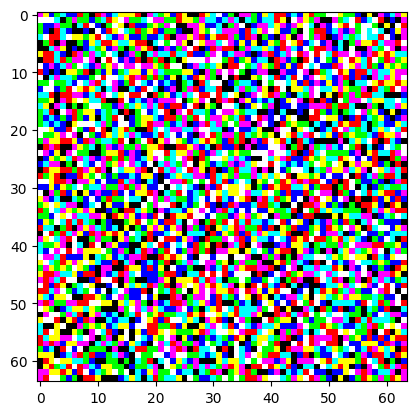

1260941265854511.8 -639730.6173713077


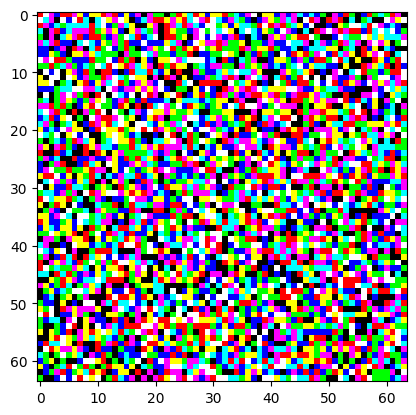

436387370400159.4 -375993.8362834573


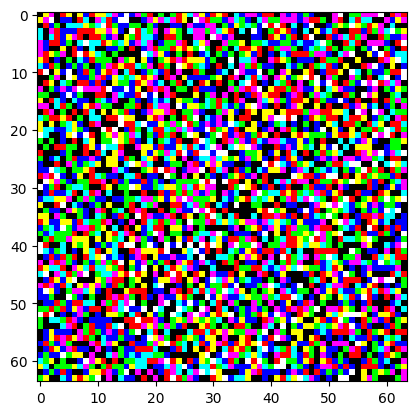

75712793863084.92 -155545.80850722958


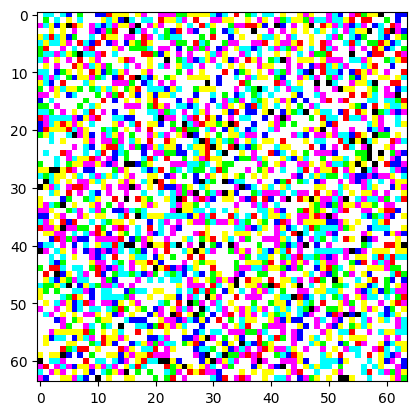

1288705288915.3037 3971.098735578716


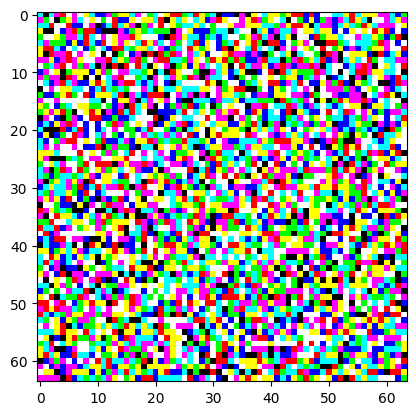

34887801956993.914 104598.6157082994


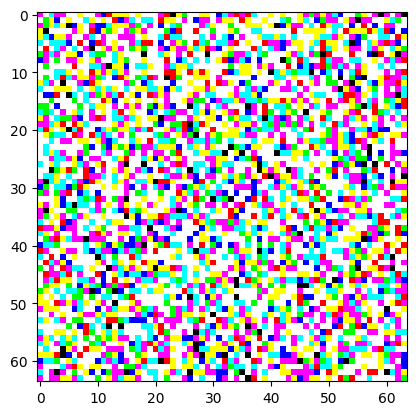

In [ ]:
losses = []
weights_mean = []
LR = 1e-4 # 1e-2 < ? < 1e-4?

m_weight4, m_bias4 = np.zeros_like(model.neuron4.weight), np.zeros_like(model.neuron4.bias)
m_weight3, m_bias3 = np.zeros_like(model.neuron3.weight), np.zeros_like(model.neuron3.bias)
m_weight2, m_bias2 = np.zeros_like(model.neuron2.weight), np.zeros_like(model.neuron2.bias)
m_weight1, m_bias1 = np.zeros_like(model.neuron1.weight), np.zeros_like(model.neuron1.bias)

v_weight4, v_bias4 = np.zeros_like(model.neuron4.weight), np.zeros_like(model.neuron4.bias)
v_weight3, v_bias3 = np.zeros_like(model.neuron3.weight), np.zeros_like(model.neuron3.bias)
v_weight2, v_bias2 = np.zeros_like(model.neuron2.weight), np.zeros_like(model.neuron2.bias)
v_weight1, v_bias1 = np.zeros_like(model.neuron1.weight), np.zeros_like(model.neuron1.bias)

for i in range(100):

    out = model.forward(input)

    loss, dmse = MSE(out, target)

    grads = model.backward()

    A = dmse @ dequantize(grads[0][1]).T
    B = A @ dequantize(grads[1][1]).T
    C = B @ dequantize(grads[2][1]).T

    w, m_weight4, v_weight4 = Adam(model.neuron4.weight, LR, (dmse.T * dequantize(grads[0][0])).T, m_weight4, v_weight4, i)
    b, m_weight4, v_weight4 = Adam(model.neuron4.bias, LR, dequantize(dmse).mean(0), m_bias4, v_bias4, i)
    model.neuron4.weight, model.neuron4.bias = np.clip(quantize(w), -1, 1), b

    w, m_weight3, v_weight3 = Adam(model.neuron3.weight, LR, (A.T @ dequantize(grads[1][0])).T, m_weight3, v_weight3, i)
    b, m_bias3, v_bias3 = Adam(model.neuron3.bias, LR, A.mean(0), m_bias3, v_bias3, i)
    model.neuron3.weight, model.neuron3.bias = np.clip(quantize(w), -1, 1), b

    w, m_weight2, v_weight2 = Adam(model.neuron2.weight, LR, (B.T @ dequantize(grads[2][0])).T, m_weight2, v_weight2, i)
    b, m_bias2, v_bias2 = Adam(model.neuron2.bias, LR, B.mean(0), m_bias2, v_bias2, i)
    model.neuron2.weight, model.neuron2.bias = np.clip(quantize(w), -1, 1), b

    w, m_weight1, v_weight1 = Adam(model.neuron1.weight, LR, (C.T @ dequantize(grads[3][0])).T, m_weight1, v_weight1, i)
    b, m_bias1, v_bias1 = Adam(model.neuron1.bias, LR, C.mean(0), m_bias1, v_bias1, i)
    model.neuron1.weight, model.neuron1.bias = np.clip(quantize(w), -1, 1), b

    losses.append(loss)
    weights_mean.append(model.neuron1.weight.mean())

    if i % 10 == 0:

        print(loss, dmse.mean())
        plt.imshow(((quantize(out)+1.0)*0.5).reshape(64, 64, 3))
        plt.show()

In [ ]:
1288705288915
34887801956993

In [ ]:
print(model.neuron4.weight)
print((model.neuron4.weight > 0).sum())
print(model.neuron4.weight.shape)
print(model.neuron4.bias)

[[-1 -1 -1 ...  1 -1 -1]
 [ 1 -1  1 ... -1  1 -1]
 [-1  1  1 ...  1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1  1]
 [-1 -1  1 ... -1 -1 -1]
 [ 1 -1 -1 ...  1 -1 -1]]
(4096, 12288)
[ 0.04284812 -0.07277697 -0.02458677 ... -0.03589285 -0.05354213
  0.01546781]


In [ ]:
print(dequantize(grads[0][1]).T)

[[-0.66666667  0.66666667 -0.66666667 ... -0.66666667 -0.66666667
   0.66666667]
 [-0.66666667 -0.66666667  0.66666667 ... -0.66666667 -0.66666667
  -0.66666667]
 [-0.66666667  0.66666667  0.66666667 ... -0.66666667  0.66666667
  -0.66666667]
 ...
 [ 0.66666667 -0.66666667  0.66666667 ... -0.66666667 -0.66666667
   0.66666667]
 [-0.66666667  0.66666667 -0.66666667 ... -0.66666667 -0.66666667
  -0.66666667]
 [-0.66666667 -0.66666667 -0.66666667 ...  0.66666667 -0.66666667
  -0.66666667]]


In [ ]:
print(out)
print(target)

[[30869.65884764 55842.61709455 36234.32966581 ... 33414.66762552
  46257.12603979 24405.54609369]]
[[1.59909295e+09 2.89272829e+09 1.87699066e+09 ... 1.73092809e+09
  2.39618600e+09 1.26424257e+09]]
[[-0.01960784  0.02745098 -0.33333333 ... -0.34117647 -0.34901961
  -0.41176471]]


In [ ]:
l1 = w1*x + b1
l2 = w2*l1 + b2
l3 = w3*l2 + b3
out = w4*l3 + b4

quant
x ---> x*S0
w1 ---> w1*S1
b1 ---> b1*S2

l1*S = w1*S1 * x*S0 + b1*S2
l1 = (w1*x)*(S1*S0)/S + (S2/S0)*b1

S = ?

S = (w1*x)*(S1*S0)/l1 + (S2/l1)*b1

In [ ]:
# https://arxiv.org/pdf/2004.09602
# https://arxiv.org/pdf/2103.13630
# https://towardsdatascience.com/inside-quantization-aware-training-4f91c8837ead
y = dequant(x) * dequant(w) + dequant(b)


In [ ]:
m = w*x + b
n = w/S1 * x/S2 + b/S3 ---> n = m/S4

m/S4 = w/S1 * x/S2 + b/S3
m = S4 * (w*x/S1*S2) + S4 * b/S3
m = (S4/S1S2)*wx + S4/S3 * b

In [ ]:
print(model.neuron4.weight)

[[-0.00867328 -0.21612645  0.04339703 ...  0.09356863  0.22057346
   0.11569729]
 [ 0.09970411 -0.04575043  0.04902176 ...  0.07377968  0.00998351
   0.17037457]
 [-0.18981889  0.14750472 -0.0055279  ...  0.05854119  0.10507497
   0.27108654]
 ...
 [ 0.17179954 -0.1038541   0.03515697 ... -0.06125926 -0.01763219
  -0.01060506]
 [ 0.00303722  0.02064155  0.06810637 ...  0.08124506 -0.13946032
  -0.04575719]
 [ 0.21812104 -0.0360969   0.23828661 ...  0.1033361   0.02436818
   0.10690391]]


In [ ]:
print(scales)
print(model.neuron4.bias)
teste = model.neuron4.bias * scales[0][1]
print(teste)
print(teste.dtype)

[[0.0392156862745098, 0.39215686274509803], [0.06274509803921569, 0.996078431372549], [0.996078431372549, 0.996078431372549], [0.996078431372549, 0.996078431372549]]
[29 14 -3 ... 15  2 -7]
[11.37254902  5.49019608 -1.17647059 ...  5.88235294  0.78431373
 -2.74509804]
float64


In [ ]:
print(model.neuron1.weight)
print(model.neuron1.weight.min(), model.neuron1.weight.max(), model.neuron1.weight.mean(), model.neuron1.weight.std())

[[-1  0 -1 ... -1  0  0]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [ 0  0 -1 ... -1 -1  0]
 [ 0 -1 -1 ...  0  0  0]
 [ 0 -1 -1 ...  0 -1  0]]
-1 0 -0.7590179443359375 0.42767944130152574


In [ ]:
print(model.neuron1.weight)
print(model.neuron1.weight.min(), model.neuron1.weight.max(), model.neuron1.weight.mean(), model.neuron1.weight.std())

[[   5   -3   -2 ...   -1   -1   -5]
 [   0   -1    3 ...   -3    5    1]
 [-109  -16   66 ... -102  107  -17]
 ...
 [  62  -81   18 ...   91 -111  -83]
 [ -83  -58  -44 ...  -54   42  -58]
 [-106   57  -56 ...  -20  -17   50]]
-128 127 -0.12593841552734375 71.60504480280892


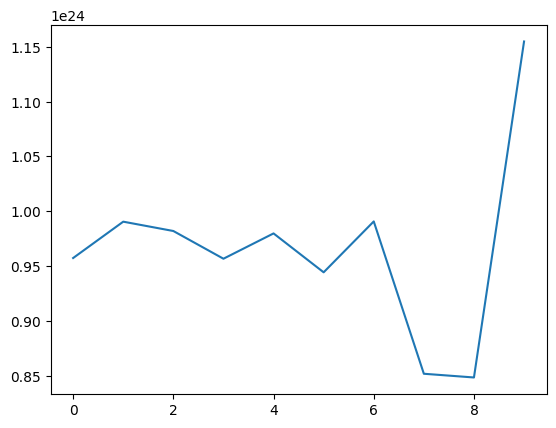

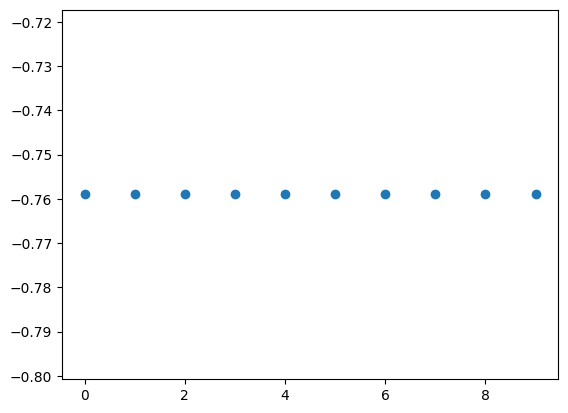

In [ ]:
plt.plot(losses)
plt.show()

plt.scatter(np.arange(len(weights_mean)), weights_mean)
plt.show()